In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from scipy.spatial.distance import squareform
import joblib
import matplotlib
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
import argparse
from scipy.spatial.distance import squareform
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import sparse
import dask.array as da
from sklearn import metrics
from sklearn.metrics import average_precision_score
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import os
import os.path
from scipy import linalg
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import pickle
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import normalize
from random import sample

In [2]:
def list_avg(l1,l2):
    l3 = []
    for j in range(len(l1)):
        l3.append((l1[j]+l2[j])/2)
    return l3

## Load DDI Data

In [3]:
edges = pd.read_csv('edge.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False, names=['node1','node2'])

In [4]:
G_ddi = nx.from_edgelist(zip(edges['node1'],edges['node2']), create_using=nx.Graph())

In [5]:
train, test = train_test_split(edges, test_size=0.2)

In [6]:
G_train = nx.from_edgelist(zip(train['node1'],train['node2']), create_using=nx.Graph())
G_test = nx.from_edgelist(zip(test['node1'],test['node2']), create_using=nx.Graph())

In [7]:
G_train_neg = nx.complement(G_train)
G_test_neg = nx.complement(G_test)

In [8]:
negative_edges_train = sample(list(G_train_neg.edges()),len(train)) 
negative_edges_test = sample(list(G_test_neg.edges()),len(test)) 

In [9]:
negative_edges_train_df = pd.DataFrame()
negative_edges_train_df['node1'] = [x[0] for x in negative_edges_train]
negative_edges_train_df['node2'] = [x[1] for x in negative_edges_train]

negative_edges_test_df = pd.DataFrame()
negative_edges_test_df['node1'] = [x[0] for x in negative_edges_test]
negative_edges_test_df['node2'] = [x[1] for x in negative_edges_test]

In [10]:
train_data = pd.concat([train,negative_edges_train_df])
train_data['Y'] = [1] * len(train) + [0] * len(negative_edges_train_df)

test_data = pd.concat([test,negative_edges_test_df])
test_data['Y'] = [1] * len(test) + [0] * len(negative_edges_test_df)

# Sense Features

In [11]:
degree_nodes = dict(G_train.degree())
clustering_coeff = nx.clustering(G_train)
triangle_nodes = dict(nx.triangles(G_train))
nn_degree = nx.average_neighbor_degree(G_train)
betweenness_cetrality = dict(nx.betweenness_centrality(G_train))

In [12]:
node_feature_dict = dict()
for node in tqdm(list(G_train.nodes())):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    node_feat_list.append(triangle_nodes[node])
    node_feat_list.append(nn_degree[node])
    node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|██████████| 4248/4248 [00:00<00:00, 523717.80it/s]


In [13]:
train_data_feature_edge_list = []
for index, row in tqdm(train_data.iterrows()):
    train_data_feature_edge_list.append(list_avg(node_feature_dict[row['node1']],node_feature_dict[row['node2']]))
    

1708656it [05:22, 5299.73it/s] 


In [14]:
X = np.array(train_data_feature_edge_list)
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(train_data['Y'].tolist())

Feature: 0, Score: 4.34050
Feature: 1, Score: 0.55755
Feature: 2, Score: -2.48089
Feature: 3, Score: -0.06480
Feature: 4, Score: -0.05505


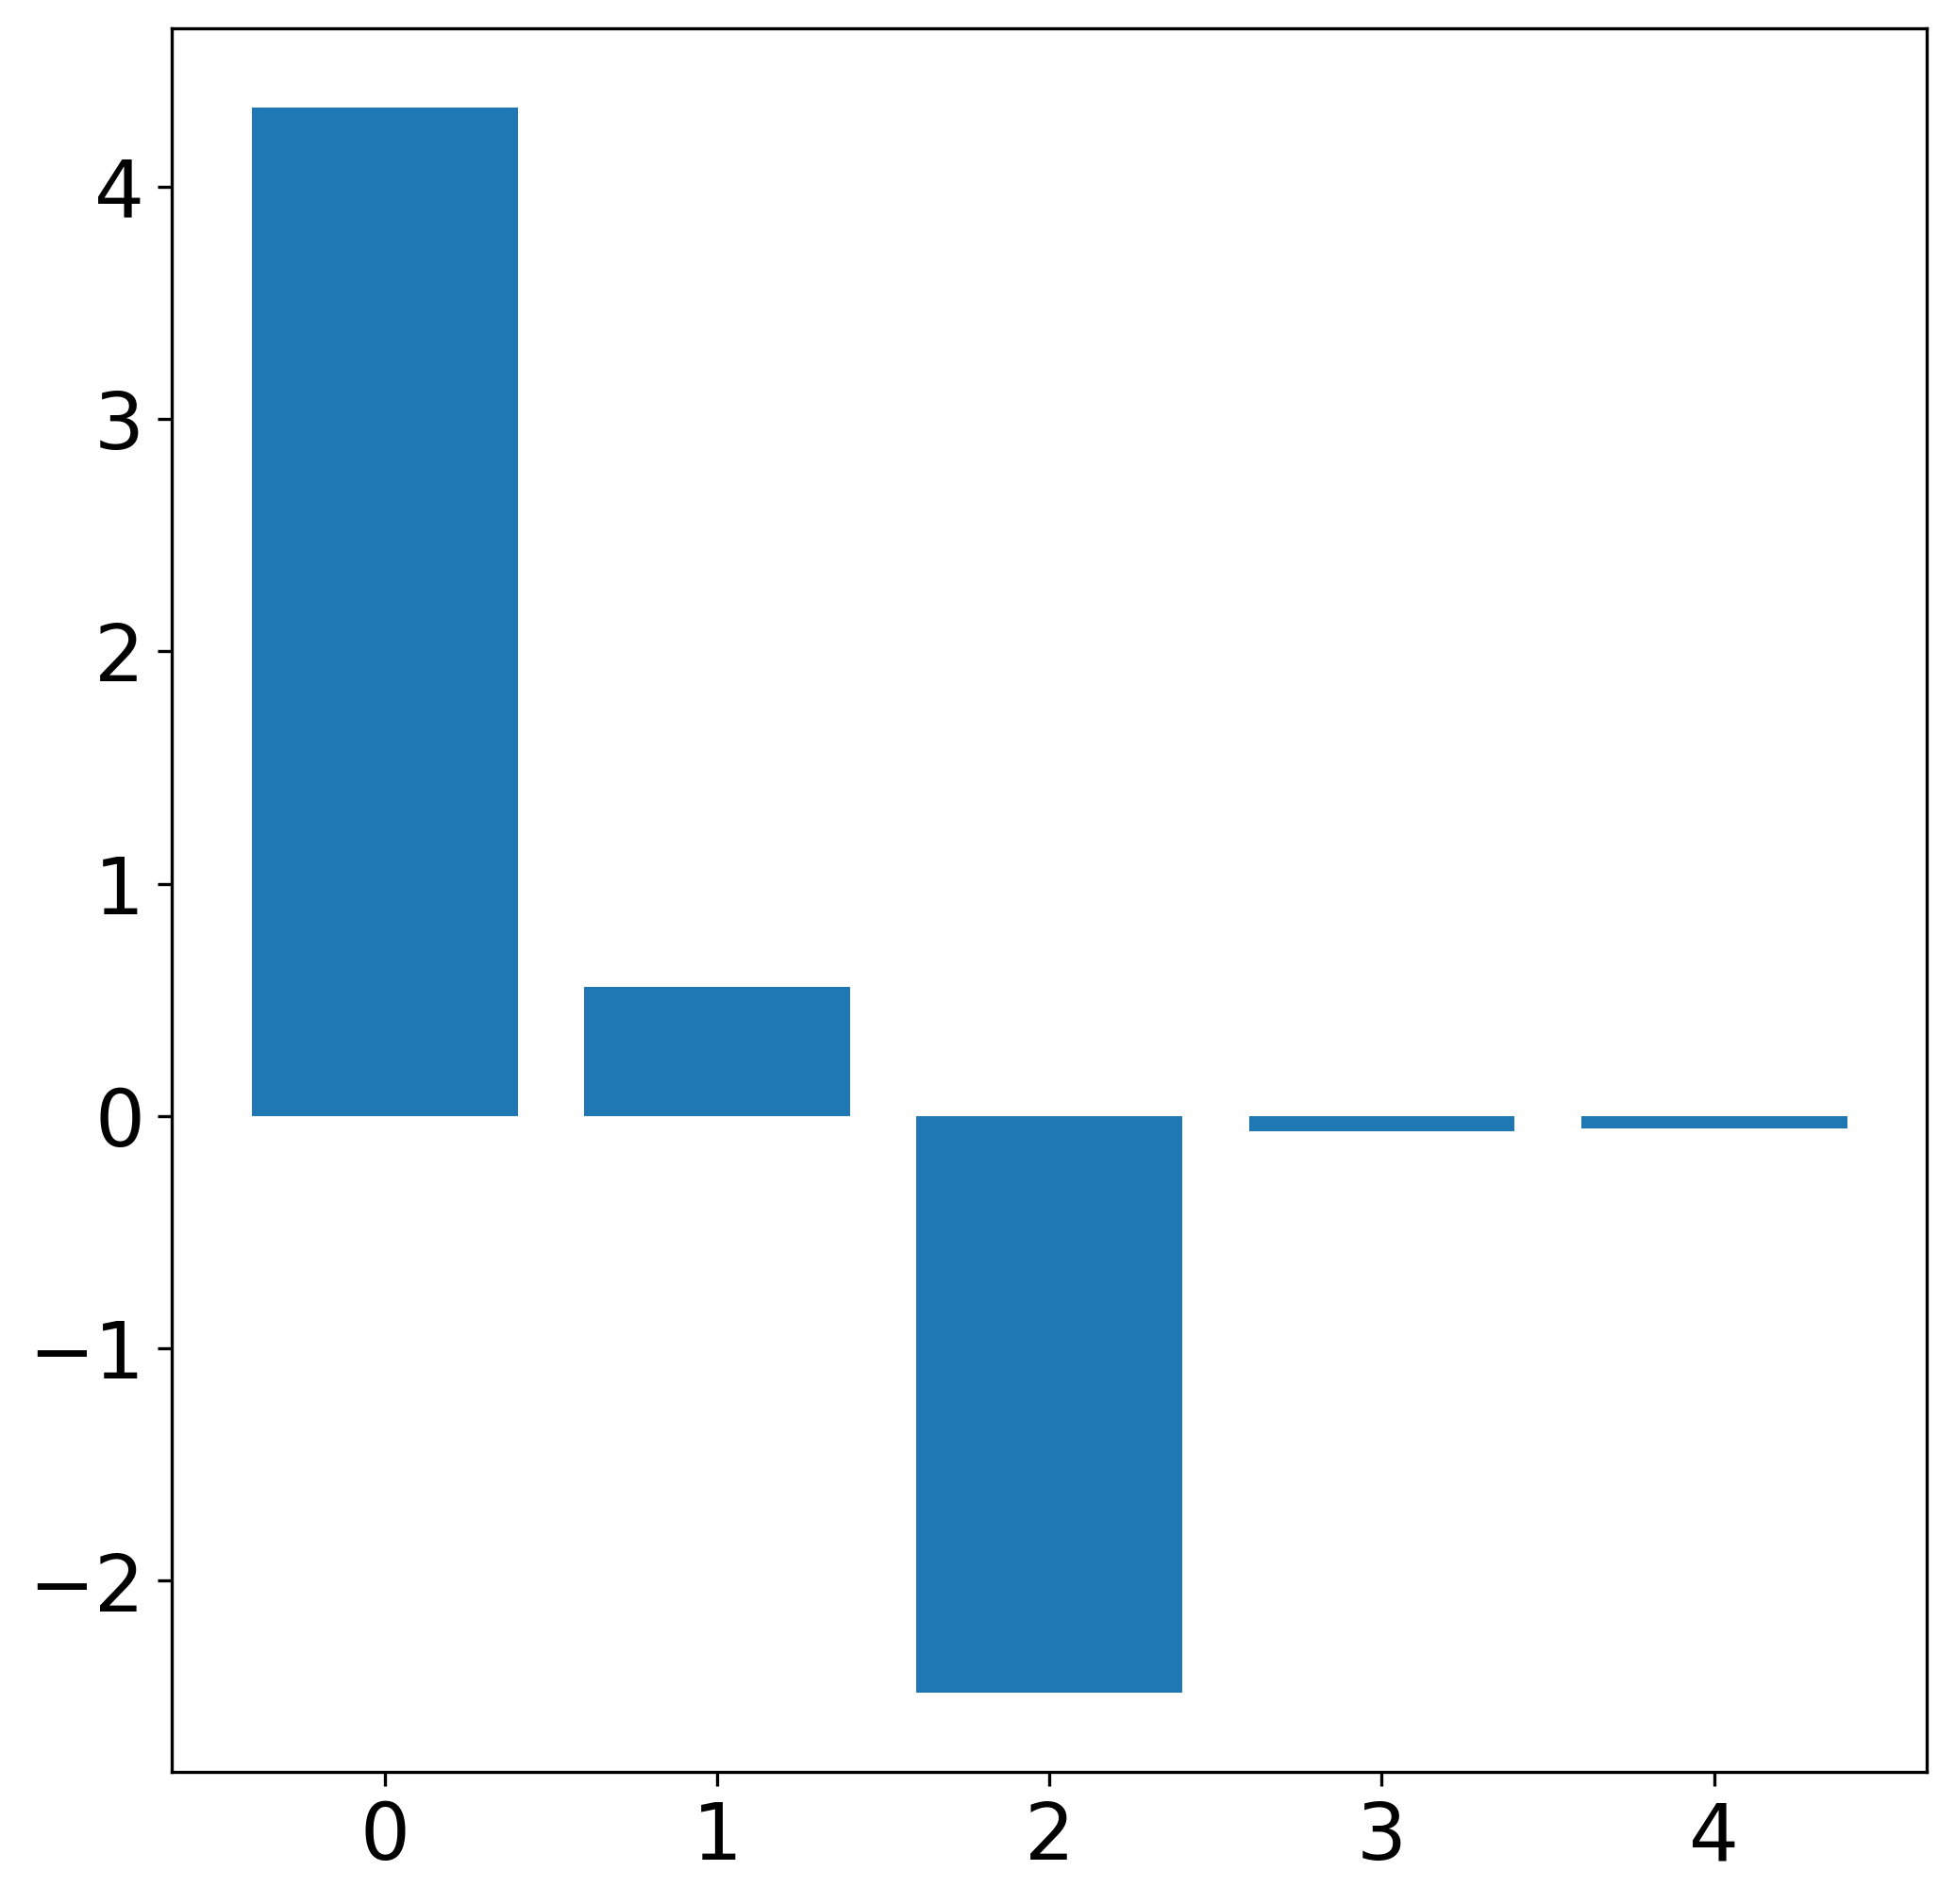

In [15]:
model = LogisticRegression()
model.fit(X, y)
importance = model.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.figure(figsize=(8, 8),dpi=300)
pyplot.bar([x for x in range(len(importance))], importance)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Test data

In [16]:
train_nodes = list(set(train_data['node1']).union(set(train_data['node2'])))
test_transductive = test_data[test_data['node1'].isin(train_nodes) & test_data['node2'].isin(train_nodes)]

In [17]:
test_data_feature_edge_list = []
for index, row in tqdm(test_transductive.iterrows()):
    test_data_feature_edge_list.append(list_avg(node_feature_dict[row['node1']],node_feature_dict[row['node2']]))

425165it [01:03, 6702.28it/s] 


In [18]:
X = np.array(test_data_feature_edge_list)
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(test_transductive['Y'].tolist())

In [19]:
y_pred = model.predict(X)

In [20]:
print('AUROC: ', roc_auc_score(y_pred,y))
print('AUPRC: ', average_precision_score(y_pred,y))

AUROC:  0.7433404992708076
AUPRC:  0.7132868583866596
